# Imports

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

np.random.seed(0)

In [2]:
module_path = os.path.abspath(os.path.join('../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import torchtrace.plotann as plotann

In [3]:
TF = 'tf'
NP = 'np'
TORCH = 'torch'

framework = TF

In [4]:
if framework == TF:
    import tensorflow as tf

# Load Data

In [5]:
def one_hot(a, nb_classes):
    assert a.ndim == 1
    N = len(a)
    M = nb_classes
    result = np.zeros((N, M), dtype=a.dtype)
    result[range(N), a] = 1
    return result

In [6]:
if framework == TORCH:
    
    from torchvision import datasets
    
    dataset_location = '~/.pytorch/MNIST_data/'
    
    trainset = datasets.MNIST(dataset_location, download=True, train=True)
    validset = datasets.MNIST(dataset_location, download=True, train=False)
    
    train_x_raw = trainset.train_data.float().numpy().reshape((-1,784)) / 255
    train_y_raw = one_hot(trainset.train_labels.numpy(), 10)
    valid_x_raw = testset.test_data.float().numpy().reshape((-1,784)) / 255
    valid_y_raw = one_hot(testset.test_labels.numpy(), 10)

In [7]:
if framework == TF:
    
    from tensorflow.examples.tutorials.mnist import input_data
    
    mnist = input_data.read_data_sets('MNIST-Dataset', one_hot=True)
    
    train_x_raw = np.concatenate((mnist.train.images, mnist.validation.images))
    train_y_raw = np.concatenate((mnist.train.labels, mnist.validation.labels))
    valid_x_raw = mnist.test.images
    valid_y_raw = mnist.test.labels

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST-Dataset/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST-Dataset/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST-Dataset/t10k-images-idx3-ubyte.gz
Extracting MNIST-Dataset/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


**Show statistics**

In [8]:
def print_help(a):
    print(f's: {str(a.shape):15} t:{str(a.dtype):7} {a.min():6.2f} {a.max():6.2f} {a.mean():6.2f} {a.std():6.2f}')

In [9]:
print_help(train_x_raw)
print_help(train_y_raw)
print_help(valid_x_raw)
print_help(valid_y_raw)

s: (60000, 784)    t:float32   0.00   1.00   0.13   0.31
s: (60000, 10)     t:float64   0.00   1.00   0.10   0.30
s: (10000, 784)    t:float32   0.00   1.00   0.13   0.31
s: (10000, 10)     t:float64   0.00   1.00   0.10   0.30


## Explore Data

In [10]:
def plot_mnist(data_x, data_y, n):
    fig = plt.figure(figsize=[16,9])
    for i in range(n):
        ax = fig.add_subplot(n//8, 8, i+1)
        ax.imshow(data_x[i].reshape([28,28]))
        ax.axis('off')
        idx = int(np.nonzero(data_y[i])[0])
        ax.set_title(idx)
    plt.show()

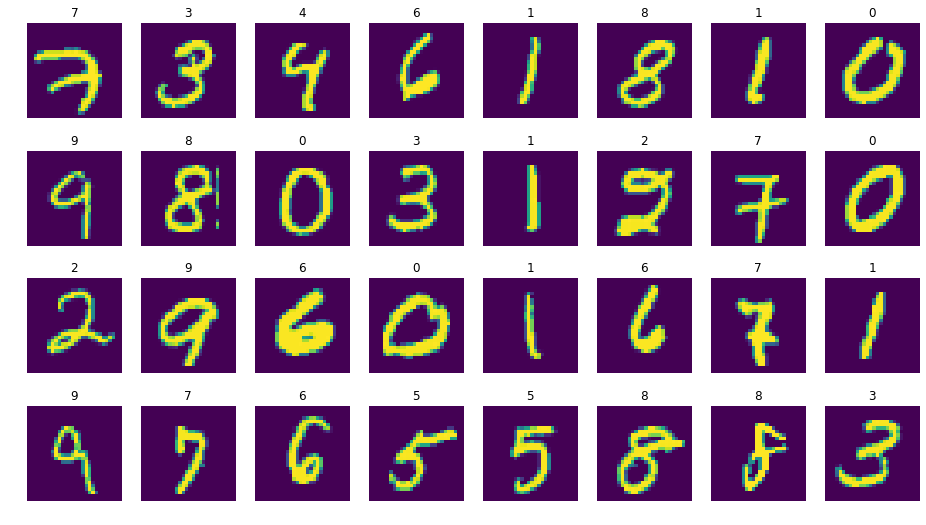

In [11]:
plot_mnist(train_x_raw, train_y_raw, 32)

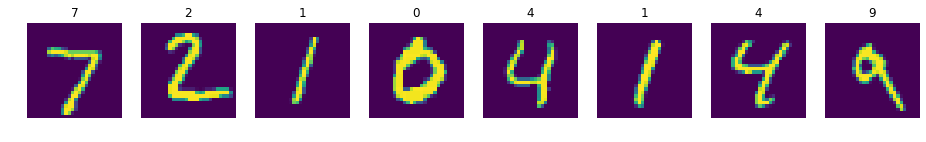

In [12]:
plot_mnist(valid_x_raw, valid_y_raw, 8)

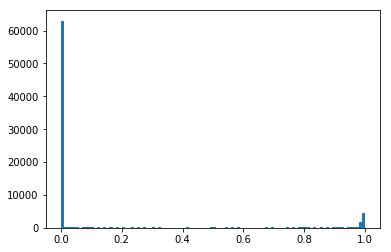

In [13]:
plt.hist(train_x_raw[0:100].flatten(), bins=100);

In [14]:
print('train mean:', train_x_raw.mean(), 'std', train_x_raw.std())
print('valid mean:', valid_x_raw.mean(), 'std', valid_x_raw.std())

train mean: 0.13066052 std 0.3081081
valid mean: 0.13251467 std 0.3104803


## Preprocess Data

In [15]:
tx_mean = train_x_raw.mean()
tx_std = train_x_raw.std()
train_x = (train_x_raw - tx_mean)/tx_std
valid_x = (valid_x_raw - tx_mean)/tx_std
train_y = train_y_raw
valid_y = valid_y_raw
print('train mean:', train_x.mean(), 'std', train_x.std())
print('valid mean:', valid_x.mean(), 'std', valid_x.std())
print(train_x.shape, train_y.shape)
print(valid_x.shape, valid_y.shape)

train mean: -1.3088466e-07 std 0.99999946
valid mean: 0.0060176537 std 1.0076991
(60000, 784) (60000, 10)
(10000, 784) (10000, 10)


In [16]:
tx_mean = train_x_raw.mean()
tx_std = train_x_raw.std()
train_x = (train_x_raw - tx_mean)/tx_std
valid_x = (valid_x_raw - tx_mean)/tx_std
train_y = train_y_raw
valid_y = valid_y_raw
print('train mean:', train_x.mean(), 'std', train_x.std())
print('valid mean:', valid_x.mean(), 'std', valid_x.std())
print(train_x.shape, train_y.shape)
print(valid_x.shape, valid_y.shape)

train mean: -1.3088466e-07 std 0.99999946
valid mean: 0.0060176537 std 1.0076991
(60000, 784) (60000, 10)
(10000, 784) (10000, 10)


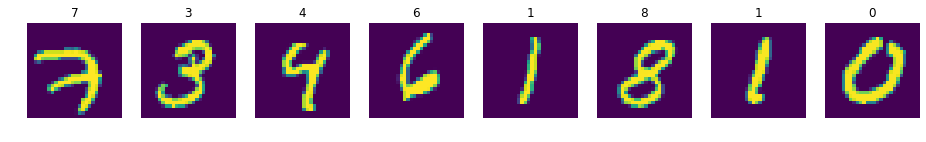

In [17]:
plot_mnist(train_x, train_y, 8)

In [18]:
def subsample_to_14_14(data):
    assert data.ndim == 2
    assert data.shape[1] == 784
    data_28x28 = data.reshape([len(data), 28, 28])  # reshape to match image resolution, new shape (nb_samples, 28, 28)
    print('28', data_28x28.shape)
    data_14x14 = data_28x28[:,::2,::2] # subsample, new shape (nb_samples, 14, 14)
    print('14', data_14x14.shape)
    data_196 = data_14x14.reshape([len(data),14*14])
    print('data_196', data_196.shape)
    assert data_196.ndim == 2
    assert data_196.shape[1] == 196
    return data_196

In [19]:
train_x = subsample_to_14_14(train_x)
valid_x = subsample_to_14_14(valid_x)

28 (60000, 28, 28)
14 (60000, 14, 14)
data_196 (60000, 196)
28 (10000, 28, 28)
14 (10000, 14, 14)
data_196 (10000, 196)


# Activation Functions

These are used for numpy model, but also for plotting later on

In [20]:
def sigmoid(x, deriv=False):
    if deriv:
        return sigmoid(x)*(1-sigmoid(x))
    return 1 / (1 + np.exp(-x))

def tanh(x, deriv=False):
    if deriv:
        return 1. - np.tanh(x)**2
    return np.tanh(x)

def softssign(x, deriv=False):
    if deriv:
        dd = 1 + np.abs(x)
        return (dd - x*np.sign(x)) / dd**2
    return x / (1+np.abs(x))

def relu(x, deriv=False):
    if deriv:
        return 1. * (x>0)
    return np.maximum(0, x)

def lrelu(x, deriv=False):
    if deriv:
        dx = np.ones_like(x)
        dx[x < 0] = 0.01
        return dx
    return np.where(x > 0, x, x * 0.01)

act_fun_dict = {'sigmoid': sigmoid, 'tanh': tanh, 'softssign':softssign,
                'relu':relu, 'lrelu':lrelu}

# Numpy Model

In [ ]:
def MSE(y, y_hat):
    assert y.ndim == 2
    assert y_hat.ndim == 2
    
    # avg over batch, sum over outputs (inner)
    return .5 * np.mean(np.sum((y-y_hat)**2, axis=-1))
    
    # no innner sum, becouse only one output
    return np.mean((y-y_hat)**2)

def acc(y, y_hat):
    return np.mean(np.argmax(y_hat, axis=-1)==np.argmax(y, axis=-1))

def fwd(x, W_hid, W_out, act_fun, ret=False):
    assert x.ndim == 2
    z_hid = x @ W_hid
    h_hid = act_fun(z_hid)  # hidden output

    z_out = h_hid @ W_out
    y_hat = sigmoid(z_out)  # SIGMOID!

    if ret:
        return y_hat, z_hid, h_hid, z_out
    return y_hat

def backprop(x, y, W_hid, W_out, act_fun):
    assert x.ndim == 2
    assert y.ndim == 2
    
    y_hat, z_hid, h_hid, z_out = fwd(x, W_hid, W_out, act_fun, ret=True)
    
    ro_out = (y-y_hat) * -1 * sigmoid(z_out, deriv=True)  # SIGMOID
    dW_out = h_hid.T @ ro_out / len(x)
    
    ro_hid = (ro_out @ W_out.T) * act_fun(z_hid, deriv=True)
    dW_hid = x.T @ ro_hid / len(x)
    
    return dW_hid, dW_out

### Numerical gradient check (optional)

In [ ]:
def ngrad(x, y, W_hid, W_out, act_fun):
    
    eps = 1e-6
    
    gW_hid = np.zeros_like(W_hid)
    for r in range(W_hid.shape[0]):
        for c in range(W_hid.shape[1]):
            W_hid_plus = W_hid.copy()
            W_hid_minus = W_hid.copy()
            W_hid_plus[r,c] += eps
            W_hid_minus[r,c] -= eps
            loss_plus = MSE(y, fwd(x, W_hid_plus, W_out, act_fun))
            loss_minus = MSE(y, fwd(x, W_hid_minus, W_out, act_fun))
            gW_hid[r,c] = (loss_plus-loss_minus) / (2*eps)

    gW_out = np.zeros_like(W_out)
    for r in range(W_out.shape[0]):
        for c in range(W_out.shape[1]):
            W_out_plus = W_out.copy()
            W_out_minus = W_out.copy()
            W_out_plus[r,c] += eps
            W_out_minus[r,c] -= eps
            loss_plus = MSE(y, fwd(x, W_hid, W_out_plus, act_fun))
            loss_minus = MSE(y, fwd(x, W_hid, W_out_minus, act_fun))
            gW_out[r,c] = (loss_plus-loss_minus) / (2*eps)
    return gW_hid, gW_out

In [ ]:
hid_dW, out_dW = backprop(train_x[0:3], train_y[0:3], W_hid, W_out, act_fun)
hid_ngW, out_ngW = ngrad(train_x[0:3], train_y[0:3], W_hid, W_out, act_fun)

In [ ]:
assert np.allclose(hid_dW, hid_ngW)
assert np.allclose(out_dW, out_ngW)

# Train Loop - with traces

In [21]:
n_in = 196   # 784
n_hid = 128  # 128  # 128             # sigmoid try 8, 128(def.), 2048
n_out = 10
lr = 0.03    # 0.03         # sigmoid try 10, 1(best), 0.03, 0.0003

if framework == NP:
    np_or_tf = 'np'
elif framework == TF:
    np_or_tf = 'tf2'

n_batch = 100
act_fun = 'relu'
completed_epochs = 0

np.random.seed(0)

# Initialize weights
var_hid = np.sqrt(1/n_in)       # sigmoid try:  0.001,  sqrt(1/n_in),  1
var_out = np.sqrt(1/n_hid)
W_hid = np.random.normal(0.0, var_hid, [n_in, n_hid])
W_out = np.random.normal(0.0, var_out, [n_hid, n_out])

batches = {'iter':[], 'loss':[], 'acc':[]}
valids = {'iter':[], 'loss':[]}
traces = {'hid_z':[], 'out_z':[],
          'hid_dW':[], 'out_dW':[],
          'hid_W':[], 'out_W':[]}

In [23]:
if np_or_tf == 'np':
    print('Skipping graph build')
    
elif np_or_tf == 'tf':
    print('Initializing TensorFlow graph')
    
    try:    sess.close()
    except: pass
    tf.reset_default_graph()
    
    nn_x = tf.placeholder(shape=[None, n_in], dtype=tf.float32)
    nn_y = tf.placeholder(shape=[None, n_out], dtype=tf.float32)

    nn_hid_W = tf.get_variable('nn_hid_W', shape=W_hid.shape, dtype=tf.float32, initializer=tf.constant_initializer(W_hid))
    nn_hid_z = tf.matmul(nn_x, nn_hid_W)
    if act_fun == 'sigmoid':
        nn_hid_h = tf.nn.sigmoid(nn_hid_z)
    elif act_fun == 'relu':
        nn_hid_h = tf.nn.relu(nn_hid_z)
    else:
        raise ValueError('unknown activation function')

    nn_out_W = tf.get_variable('nn_out_W', shape=W_out.shape, dtype=tf.float32, initializer=tf.constant_initializer(W_out))
    nn_out_z = tf.matmul(nn_hid_h, nn_out_W)
    nn_y_hat = tf.nn.sigmoid(nn_out_z)  # output always sigmoid

    nn_mse = .5 * tf.reduce_mean( tf.reduce_sum(tf.pow(nn_y-nn_y_hat, 2), axis=-1) )
    nn_acc = tf.reduce_mean( 
                tf.cast( 
                    tf.equal( tf.argmax(nn_y_hat, axis=-1), tf.argmax(nn_y, axis=-1) )
                , tf.float32)
            )

    optimizer = tf.train.GradientDescentOptimizer(learning_rate=lr)
    # optimizer = tf.train.RMSPropOptimizer(learning_rate=lr)
    # train_op = optimizer.minimize(nn_mse)

    grads_and_vars = optimizer.compute_gradients(nn_mse)
    train_op = optimizer.apply_gradients(grads_and_vars)

    nn_hid_dW = grads_and_vars[0][0]
    nn_out_dW = grads_and_vars[1][0]

    sess = tf.Session()
    sess.run(tf.global_variables_initializer())
elif np_or_tf == 'tf2':
    print('Initializing TensorFlow graph - High Level API')
    
    try:    sess.close()
    except: pass
    tf.reset_default_graph()
    
    nn_x = tf.placeholder(shape=[None, n_in], dtype=tf.float32)
    nn_y = tf.placeholder(shape=[None, n_out], dtype=tf.float32)
    
    nn_hid_h = tf.layers.dense(inputs=nn_x,
                               units=n_hid,
                               activation=tf.nn.relu,
                               use_bias=False,
                               kernel_initializer=tf.constant_initializer(W_hid),
                               name='Hidden')
    nn_hid_z = tf.get_default_graph().get_tensor_by_name('Hidden/MatMul:0')
    
    nn_y_hat = tf.layers.dense(inputs=nn_hid_h,
                               units=n_out,
                               activation=tf.nn.sigmoid,
                               use_bias=False,
                               kernel_initializer=tf.constant_initializer(W_out),
                               name='Output')
    nn_out_z = tf.get_default_graph().get_tensor_by_name('Output/MatMul:0')
        
    nn_mse = .5 * tf.reduce_mean( tf.reduce_sum(tf.pow(nn_y-nn_y_hat, 2), axis=-1) )
    nn_acc = tf.reduce_mean( 
                tf.cast( 
                    tf.equal( tf.argmax(nn_y_hat, axis=-1), tf.argmax(nn_y, axis=-1) )
                , tf.float32)
            )
    
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=lr)
    
    grads_and_vars = optimizer.compute_gradients(nn_mse)
    train_op = optimizer.apply_gradients(grads_and_vars)
    
    nn_hid_dW = grads_and_vars[0][0]
    nn_out_dW = grads_and_vars[1][0]
    
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())

Initializing TensorFlow graph - High Level API
Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [24]:
# writer = tf.summary.FileWriter(logdir='tf_log', graph=sess.graph)
# writer.flush()

In [25]:
ti_ = 0
train_i = np.array(range(len(train_x)))
for e in range(10):
    print(e)
    np.random.shuffle(train_i)
            
    for i in range(0, len(train_x), n_batch):

        # Get 128 sized batch, both as 2d arrays   
        batch = train_i[i:i+n_batch]
        x = train_x[batch]
        y = train_y[batch]
        
        if np_or_tf == 'np':
            
            if ti_ == 0:
                print('Executing Numpy version')
            
            # Forward pass
            y_hat, hid_z, _, out_z = fwd(x, W_hid, W_out, act_fun_dict[act_fun], ret=True)
            loss = MSE(y, y_hat)
            accuracy = acc(y, y_hat)
            
            # Backpropagation
            hid_dW, out_dW = backprop(x, y, W_hid, W_out, act_fun_dict[act_fun])
            W_hid += -lr * hid_dW
            W_out += -lr * out_dW
            
            y_hat = fwd(valid_x, W_hid, W_out, act_fun_dict[act_fun])
            loss_val = MSE(valid_y, y_hat)
            
        elif np_or_tf == 'tf':
            
            if ti_ == 0:
                print('Executing Tensorflow version')
            
            _, y_hat, hid_z, out_z, loss, accuracy, hid_dW, out_dW = sess.run(
                [train_op, nn_y_hat, nn_hid_z, nn_out_z, nn_mse, nn_acc, nn_hid_dW, nn_out_dW],
                feed_dict={nn_x: x, nn_y:y})
            W_hid, W_out = sess.run(tf.trainable_variables())
            
            loss_val = sess.run(nn_mse, feed_dict={nn_x: valid_x, nn_y:valid_y})
            
            assert y_hat.shape == y.shape
            assert np.isscalar(loss)
            assert np.isscalar(accuracy)
            
        elif np_or_tf == 'tf2':
            
            if ti_ == 0:
                print('Executing Tensorflow version - High Level API')
            
            _, y_hat, hid_z, out_z, loss, accuracy, hid_dW, out_dW = sess.run(
                [train_op, nn_y_hat, nn_hid_z, nn_out_z, nn_mse, nn_acc, nn_hid_dW, nn_out_dW],
                feed_dict={nn_x: x, nn_y:y})
            W_hid, W_out = sess.run(tf.trainable_variables())
            
            loss_val = sess.run(nn_mse, feed_dict={nn_x: valid_x, nn_y:valid_y})
            
            
            assert y_hat.shape == y.shape
            assert np.isscalar(loss)
            assert np.isscalar(accuracy)
            
            
        else:
            raise ValueError('np_or_tf must be "np" or "tf"')
        
        batches['iter'].append(ti_)
        batches['loss'].append(loss)
        batches['acc'].append(accuracy)
        
        valids['iter'].append(ti_)
        valids['loss'].append(loss_val)
        
        traces['hid_z'].append(hid_z)
        traces['out_z'].append(out_z)
        traces['hid_dW'].append(hid_dW)
        traces['out_dW'].append(out_dW)
        traces['hid_W'].append(W_hid.copy())
        traces['out_W'].append(W_out.copy())

        ti_ += 1
        
    completed_epochs += 1
    
expstr = 'Network(' + np_or_tf + '): '
expstr += str(n_in) + 'in->' + str(n_hid) + act_fun + '->' + str(n_out) + 'sig   '
expstr += 'init_var=[' + str(round(var_hid, 3)) + ',' + str(round(var_out,3))+ ']   '
expstr += 'lr=' + str(lr) + '   '
expstr += 'batch=' + str(n_batch) + '   '
expstr += 'epochs=' + str(completed_epochs)

tr_hid_z = np.array(traces['hid_z'])
tr_out_z = np.array(traces['out_z'])
tr_hid_dW = np.array(traces['hid_dW'])
tr_out_dW = np.array(traces['out_dW'])
tr_hid_W = np.array(traces['hid_W'])
tr_out_W = np.array(traces['out_W'])

print('tr_hid_z', tr_hid_z.shape, tr_hid_z.size/1e6)
print('tr_out_z', tr_out_z.shape, tr_out_z.size/1e6)
print('tr_hid_dW', tr_hid_dW.shape, tr_hid_dW.size/1e6)
print('tr_out_dW', tr_out_dW.shape, tr_out_dW.size/1e6)
print('tr_hid_W', tr_hid_W.shape, tr_hid_W.size/1e6)
print('tr_out_W', tr_out_W.shape, tr_out_W.size/1e6)

print(expstr)

0
Executing Tensorflow version - High Level API
1
2
3
4
5
6
7
8
9
tr_hid_z (6000, 100, 128) 76.8
tr_out_z (6000, 100, 10) 6.0
tr_hid_dW (6000, 196, 128) 150.528
tr_out_dW (6000, 128, 10) 7.68
tr_hid_W (6000, 196, 128) 150.528
tr_out_W (6000, 128, 10) 7.68
Network(tf2): 196in->128relu->10sig   init_var=[0.071,0.088]   lr=0.03   batch=100   epochs=10


# Loss, output

Network(tf2): 196in->128relu->10sig   init_var=[0.071,0.088]   lr=0.03   batch=100   epochs=10


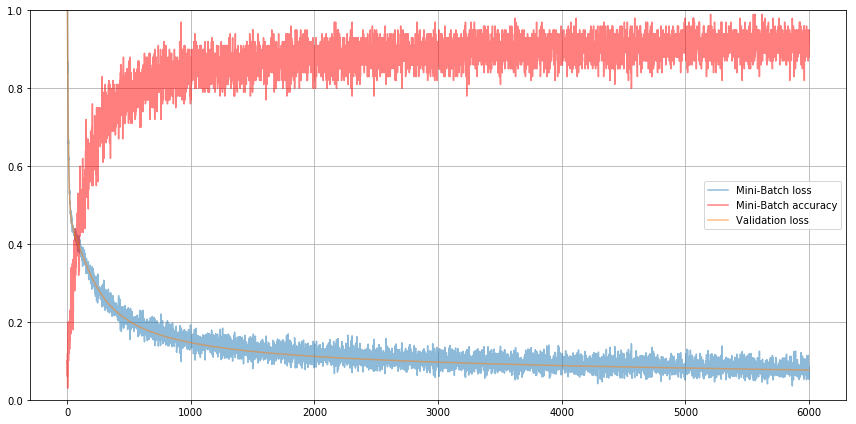

In [26]:
#
#   Plot Loss, Accuracy
#
print(expstr)
fig, ax = plt.subplots(figsize=[12,6])
ax.plot(batches['iter'], batches['loss'], label='Mini-Batch loss', alpha=.5)
ax.plot(batches['iter'], batches['acc'], label='Mini-Batch accuracy', color='red', alpha=.5)
ax.plot(valids['iter'], valids['loss'], label='Validation loss', alpha=.5)

ax.legend()
ax.set_ylim(0, 1)
ax.grid()

plt.tight_layout()
plt.show;

---

In [27]:
def plot_class_coverage(y, y_hat, axis=None):
    #
    #   Per-class accuracy
    #
    assert y.ndim == 2 and y_hat.ndim == 2
    assert y.shape == y_hat.shape
    
    nb_classses = y.shape[-1]
    
    y_correct = np.argmax(y, axis=-1) == np.argmax(y_hat, axis=-1)
    classes_correct = []
    classes_all = []
    for i in range(nb_classses):
        is_y_class_i = y_correct * (np.argmax(y, axis=-1)==i)
        nb_correct_class_i = np.sum(is_y_class_i)
        classes_correct.append(nb_correct_class_i)
        classes_all.append(np.count_nonzero(np.argmax(y, axis=-1)==i))
    classes_correct = np.array(classes_correct)
    classes_all = np.array(classes_all)

    if axis is None:
        fig, axis = plt.subplots()
    
    axis.bar(range(10), classes_all, label='All Member')
    axis.bar(range(10), classes_correct, label='Correctly Predicted')
    axis.legend(loc=3)

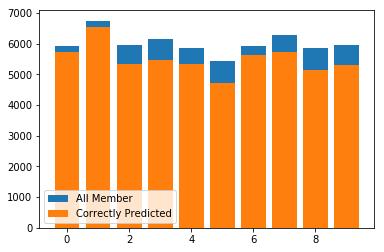

In [28]:
data_x, data_y = train_x, train_y
if np_or_tf == 'np':              y_hat = fwd(data_x, W_hid, W_out, act_fun_dict[act_fun])
elif np_or_tf in ['tf', 'tf2']:   y_hat = sess.run(nn_y_hat, feed_dict={nn_x: data_x})
else:                             raise ValueError()
plot_class_coverage(data_y, y_hat)

# Weight Plots

In [29]:
def running_mean(x, n):
    return np.array([ np.mean(x[max(i-n+1, 0): i+1]) for i in range(len(x))])

In [30]:
def running_std(x, n):
    return np.array([ np.std(x[max(i-n+1, 0): i+1]) for i in range(len(x))])

---

### Hidden

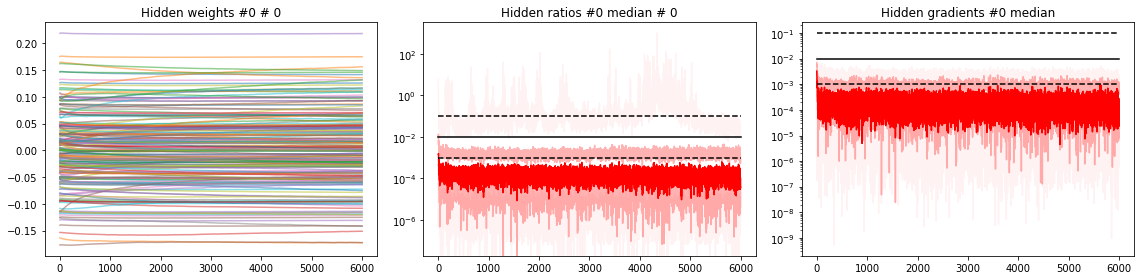

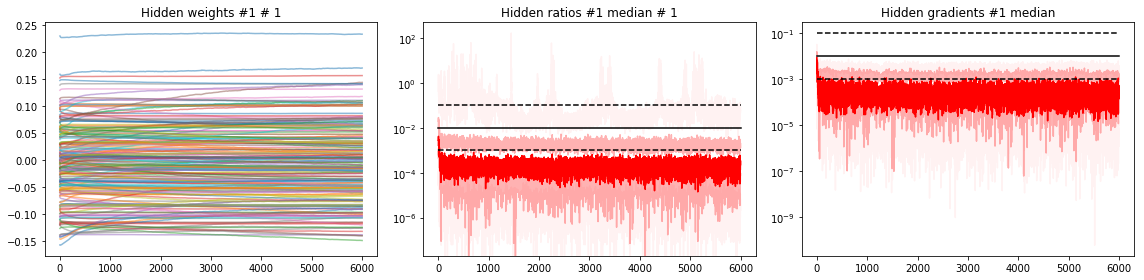

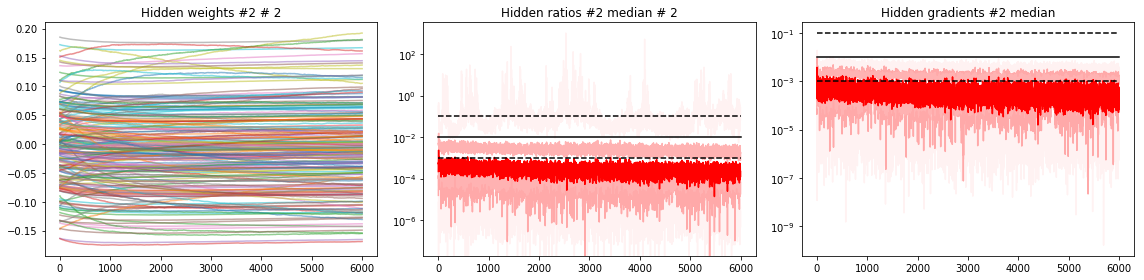

In [31]:
plotann.show_neurons_weights(tr_hid_W, tr_hid_dW, neurons=range(3),
                            title_prefix='Hidden', color='red', figsize=[16,4])

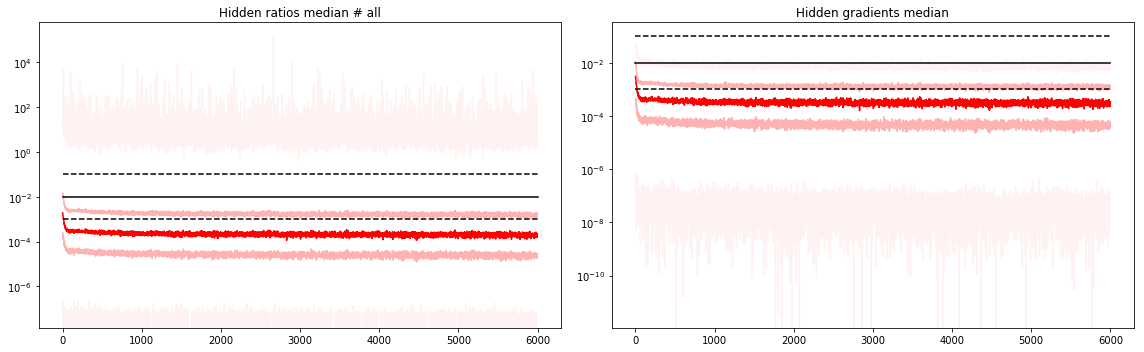

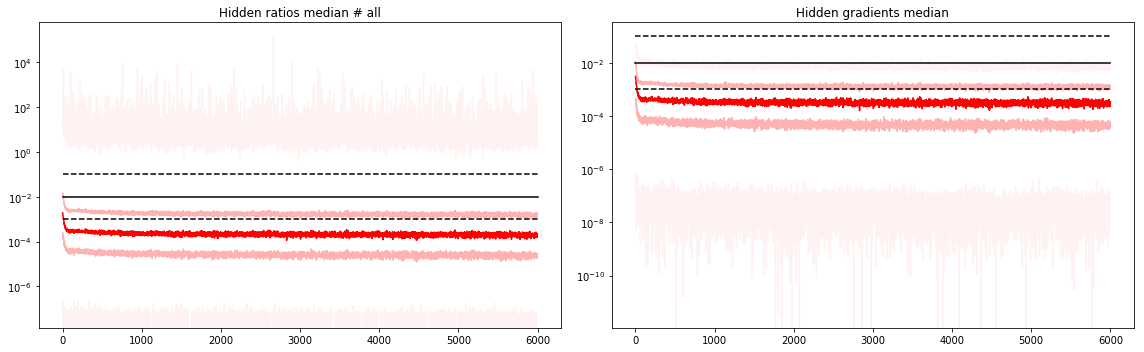

In [32]:
plotann.show_layer_summary(tr_hid_W, tr_hid_dW,
                           title_prefix='Hidden', color='red', figsize=[16,5])

### Output

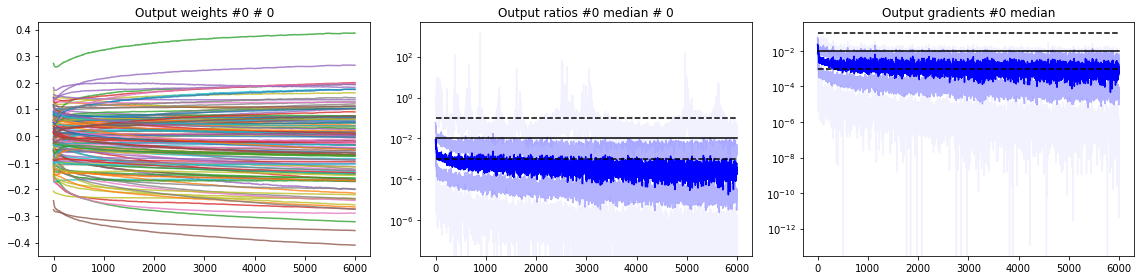

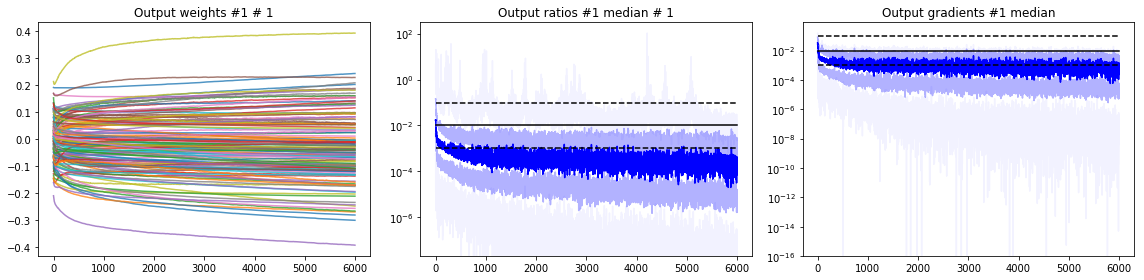

In [35]:
plotann.show_neurons_weights(tr_out_W, tr_out_dW, neurons=range(2),
                            title_prefix='Output', color='blue', figsize=[16,4])

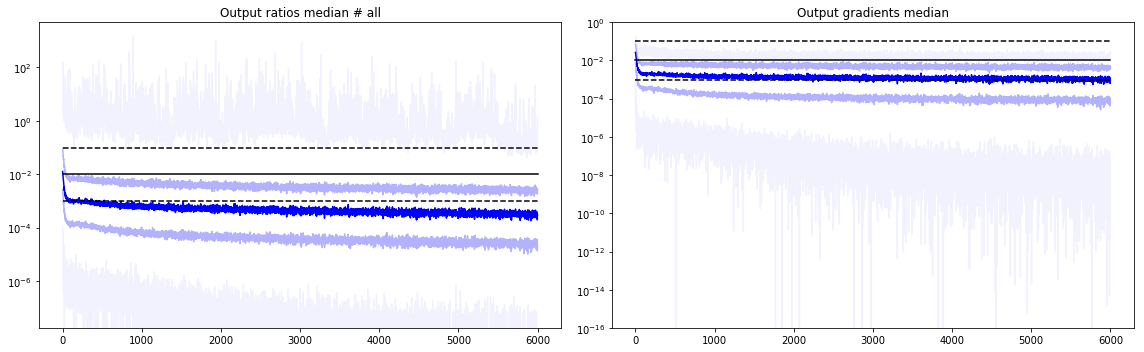

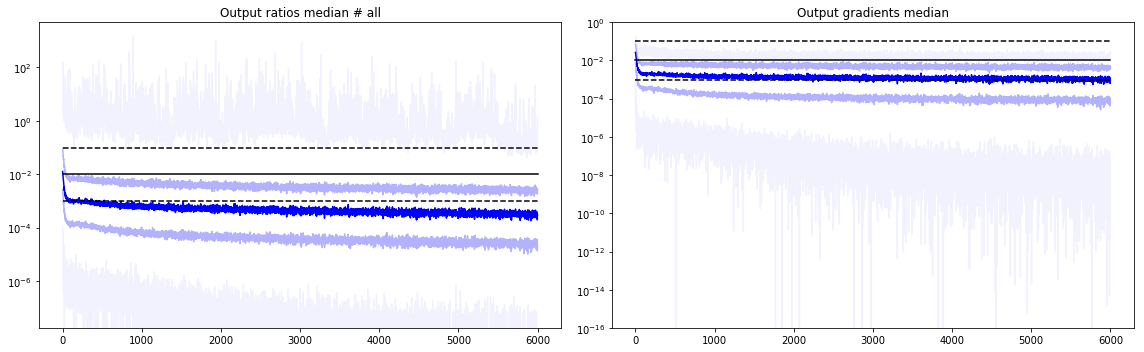

In [34]:
plotann.show_layer_summary(tr_out_W, tr_out_dW, title_prefix='Output', color='blue', figsize=[16,5])

# Activations

### Hidden

In [37]:
es = len(train_x)

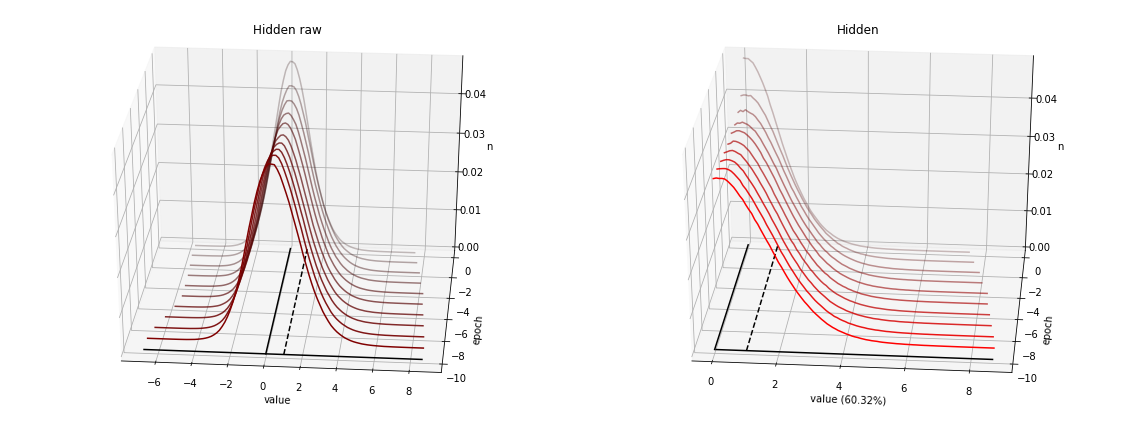

In [38]:
plotann.show_layer_activations(tr_hid_z, epoch_size=es, activation_function=act_fun,
                               title_prefix='Hidden', color=(1,0,0,1), figsize=[16,6])

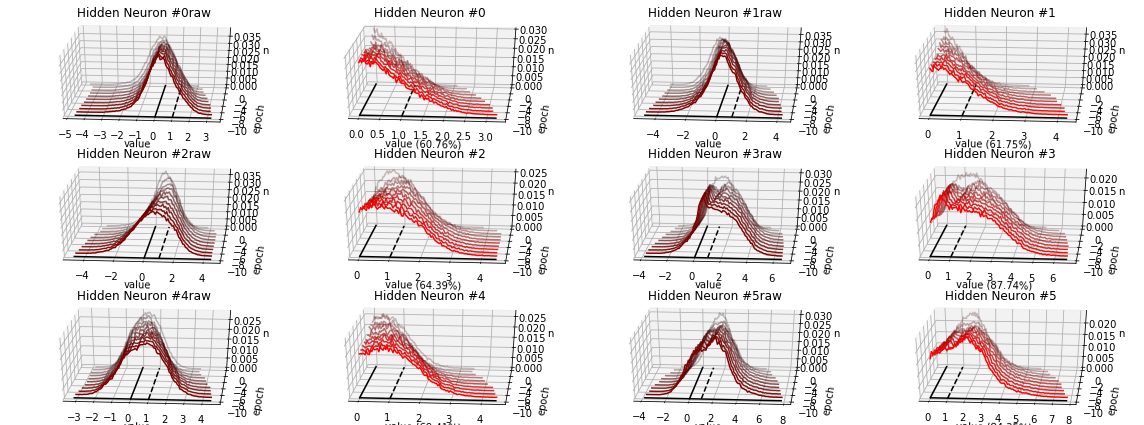

In [39]:
plotann.show_neurons_activations(tr_hid_z, epoch_size=es, activation_function=act_fun, neurons=range(6),
                                 title_prefix='Hidden', color=(1,0,0,1))

---

### Output

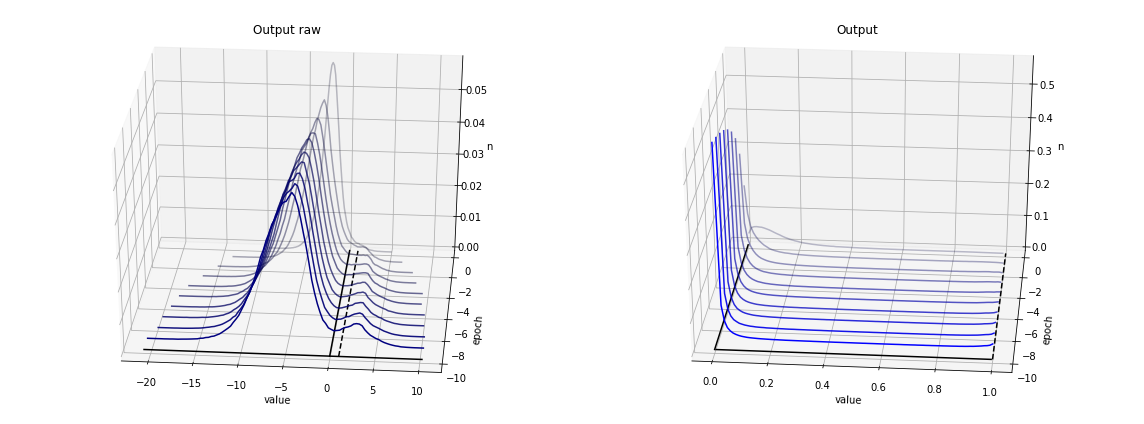

In [40]:
plotann.show_layer_activations(tr_out_z, epoch_size=es, activation_function='sigmoid',
                               title_prefix='Output', color=(0,0,1,1), figsize=[16,6])

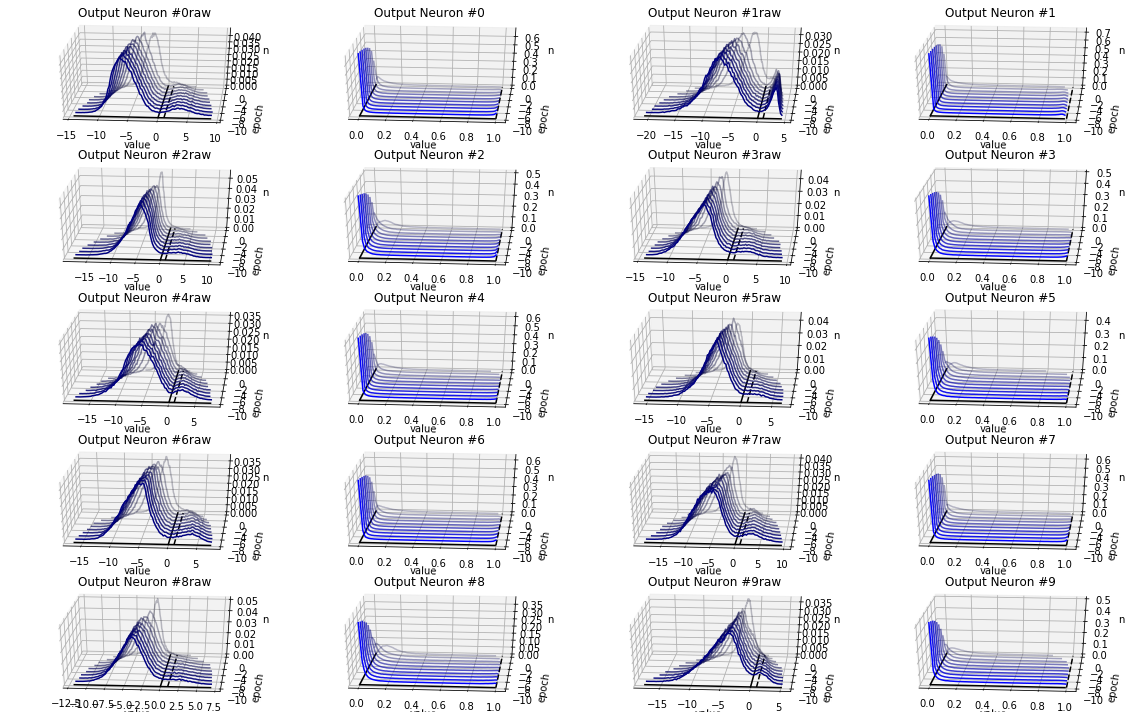

In [41]:
plotann.show_neurons_activations(tr_out_z, epoch_size=es, activation_function='sigmoid', neurons=range(tr_out_z.shape[-1]),
                                 title_prefix='Output', color=(0,0,1,1))